In [1]:
%load_ext autoreload

import pathlib

In [2]:
%autoreload 1
from dataset_utils import mk_dataset

In [3]:
def gends(ds_root, suffix, batch_size):
    ds_root = pathlib.Path(ds_root)
    pathlist = ds_root.glob(f"map/*.{suffix}")
    pathlist = sorted([path.name for path in pathlist])
    sat_pathlist = sorted([str(ds_root / "sat" / path) for path in pathlist])
    map_pathlist = sorted([str(ds_root / "map" / path) for path in pathlist])
    test_ds = mk_dataset.mkds(sat_pathlist, map_pathlist, batch_size=batch_size, test=True)
    return test_ds



ds_root = "../../DataSets/mass_roads256/test/"
suffix = "png"
test_ds = gends(ds_root, suffix, 32)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-12-28 23:41:15.817228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-28 23:41:15.817304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
inp, tar = next(iter(test_ds))


2021-12-28 23:41:15.904074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
from model import losses
diceloss = losses.DICELoss()

In [6]:
diceloss(tar, tar)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2549591>

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from typing import Optional

class Augment(layers.Layer):
    def __init__(
        self,
        zoom_rate: Optional[float]=None,
        flip_mode: Optional[str]=None,
        rotate_rate: Optional[float]=None,
        trans_rate: Optional[float]=None,
    ):
        super().__init__()

        seed = 99
        interpolation = "nearest"

        self.inputs_augment = keras.models.Sequential(name='inputs_augment')
        self.labels_augment = keras.models.Sequential(name='labels_augment')
        # fmt:off
        if zoom_rate:
            self.inputs_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))
            self.labels_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))

        if flip_mode:
            self.inputs_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))
            self.labels_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))

        if rotate_rate:
            self.inputs_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))

        if trans_rate:
            self.inputs_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))
       # fmt:on

    def call(self, inputs, labels):
        with tf.device("/cpu:0"):
            inputs = self.inputs_augment(inputs)
            labels = self.labels_augment(labels)

        return inputs, labels


In [12]:
augment = Augment(
    flip_mode="horizontal_and_vertical",
    zoom_rate=0.2,
    rotate_rate=0.2,
    trans_rate=0.2,
)


ds_root = pathlib.Path("../../DataSets/mass_roads256/test")
suffix = "png"
batch_size = 32
dsrate = 1.0

nbmix = 3

(
    ((tr_sat_pathlist, tr_map_pathlist), tr_steps),
    ((va_sat_pathlist, va_map_pathlist), va_steps),
) = mk_dataset.mk_pathlist(
    ds_root,
    suffix,
    batch_size=batch_size,
    dsrate=dsrate,
)

train_ds = mk_dataset.mkds(
    tr_sat_pathlist,
    tr_map_pathlist,
    augment=augment,
    batch_size=batch_size,
)


In [14]:
inp, tar = next(iter(train_ds))

diceloss(tar, tar)

2021-12-29 00:02:00.362760: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

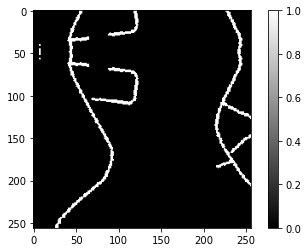

In [21]:
import matplotlib.pyplot as plt

plt.imshow(tar[1], cmap="gray")
plt.colorbar()
plt.show()
